In [7]:
import numpy as np
import pandas as pd
from skimage import measure
from scipy import misc
from scipy.ndimage import rotate
import seaborn as sns
import matplotlib.pylab as plt


'''
Shifts 2d array along given axis.
array_to_shift : 2d array that is to be shifted
n : array will be shifted by n places
axis : shift along this axis (should be 0 or 1)
'''


def shift_2d(array_to_shift, n, axis):
    shifted_array = np.zeros_like(array_to_shift)
    if axis == 0:  # shift along x axis
        if n == 0:
            return array_to_shift
        if n > 0:
            shifted_array[:, :n] = 0
            shifted_array[:, n:] = array_to_shift[:, :-n]
        else:
            shifted_array[:, n:] = 0
            shifted_array[:, :n] = array_to_shift[:, -n:]

    if axis == 1:  # shift along y axis
        if n == 0:
            return array_to_shift
        elif n > 0:
            shifted_array[-n:, :] = 0
            shifted_array[:-n, :] = array_to_shift[n:, :]
        else:
            shifted_array[:-n, :] = 0
            shifted_array[-n:, :] = array_to_shift[:n, :]
    return shifted_array


# shifts array by x and y
def get_shifted_map(firing_rate_map, x, y):
    shifted_map = shift_2d(firing_rate_map, x, 0)
    shifted_map = shift_2d(shifted_map, y, 1)
    return shifted_map


# remove from both where either of them is 0
def remove_zeros(array1, array2):
    array2 = np.nan_to_num(array2).flatten()
    array1 = np.nan_to_num(array1).flatten()
    array2_tmp = np.take(array2, np.where(array1 != 0))
    array1_tmp = np.take(array1, np.where(array2 != 0))
    array2 = np.take(array2_tmp, np.where(array2_tmp[0] != 0))
    array1 = np.take(array1_tmp, np.where(array1_tmp[0] != 0))
    return array1.flatten(), array2.flatten()


# remove from both where either of them is not a number (nan) - I am not proud of this, but nothing worked with np.nan
def remove_nans(array1, array2):
    array2 = array2.flatten()
    array2[np.isnan(array2)] = 666
    array1 = array1.flatten()
    array1[np.isnan(array1)] = 666
    array2_tmp = np.take(array2, np.where(array1 != 666))
    array1_tmp = np.take(array1, np.where(array2 != 666))
    array2 = np.take(array2_tmp, np.where(array2_tmp[0] != 666))
    array1 = np.take(array1_tmp, np.where(array1_tmp[0] != 666))
    return array1.flatten(), array2.flatten()



'''
The array is shifted along the x and y axes into every possible position where it overlaps with itself starting from
the position where the shifted array's bottom right element overlaps with the top left of the map. Correlation is
calculated for all positions and returned as a correlation_vector. The correlation vector is 2x * 2y.
'''


def get_rate_map_autocorrelogram(firing_rate_map):
    length_y = firing_rate_map.shape[0] - 1
    length_x = firing_rate_map.shape[1] - 1
    correlation_vector = np.empty((length_x * 2 + 1, length_y * 2 + 1)) * 0
    for shift_x in range(-length_x, length_x):
        for shift_y in range(-length_y, length_y):
            # shift map by x and y and remove extra bits
            shifted_map = get_shifted_map(firing_rate_map, shift_x, -shift_y)
            firing_rate_map_to_correlate, shifted_map = remove_zeros(firing_rate_map, shifted_map)

            correlation_y = shift_y + length_y
            correlation_x = shift_x + length_x

            if len(shifted_map) > 20:
                # np.corrcoef(x,y)[0][1] gives the same result for 1d vectors as matlab's corr(x,y) (Pearson)
                # https://stackoverflow.com/questions/16698811/what-is-the-difference-between-matlab-octave-corr-and-python-numpy-correlate
                correlation_vector[correlation_x, correlation_y] = np.corrcoef(firing_rate_map_to_correlate, shifted_map)[0][1]
            else:
                correlation_vector[correlation_x, correlation_y] = np.nan
    return correlation_vector


# make autocorr map binary based on threshold
def threshold_autocorrelation_map(autocorrelation_map, threshold=0.2):
    autocorrelation_map[autocorrelation_map > threshold] = 1
    autocorrelation_map[autocorrelation_map <= threshold] = 0
    return autocorrelation_map


# find peaks of autocorrelogram
def find_autocorrelogram_peaks(autocorrelation_map):
    autocorrelation_map_thresholded = threshold_autocorrelation_map(autocorrelation_map)
    autocorr_map_labels = measure.label(autocorrelation_map_thresholded)  # each field is labelled with a single digit
    field_properties = measure.regionprops(autocorr_map_labels)
    return field_properties


# calculate distances between the middle of the rate map autocorrelogram and the field centres
def find_field_distances_from_mid_point(autocorr_map, field_properties):
    distances = []
    mid_point_coord_x = np.ceil(autocorr_map.shape[0] / 2)
    mid_point_coord_y = np.ceil(autocorr_map.shape[1] / 2)

    for field in range(len(field_properties)):
        field_central_x = field_properties[field].centroid[0]
        field_central_y = field_properties[field].centroid[1]
        distance = np.sqrt(np.square(field_central_x - mid_point_coord_x) + np.square(field_central_y - mid_point_coord_y))
        distances.append(distance)
    return distances


# calculate distances between the middle of the rate map autocorrelogram and the field centres
def find_shortest_distance_from_middle_to_field(autocorr_map, field_properties):
    distances = []
    mid_point_coord_x = np.ceil(autocorr_map.shape[0] / 2)
    mid_point_coord_y = np.ceil(autocorr_map.shape[1] / 2)

    for field in range(len(field_properties)):
        field_central_x = field_properties[field].centroid[0]
        field_central_y = field_properties[field].centroid[1]
        distance = np.sqrt(np.square(field_central_x - mid_point_coord_x) + np.square(field_central_y - mid_point_coord_y))
        distances.append(distance)
    return distances


'''
Grid spacing/wavelength:
Defined by Hafting, Fyhn, Molden, Moser, Moser (2005) as the distance from the central autocorrelogram peak to the
vertices of the inner hexagon in the autocorrelogram (the median of the six distances). This should be in cm.
'''


def calculate_grid_spacing(field_distances, bin_size):
    grid_spacing = np.median(field_distances) * bin_size
    return grid_spacing


'''
Defined by Wills, Barry, Cacucci (2012) as the square root of the area of the central peak of the autocorrelogram
divided by pi. (This should be in cm2.)
'''


def calculate_field_size(field_properties, field_distances, bin_size):
    central_field_index = np.argmin(field_distances)
    field_size_pixels = field_properties[central_field_index].area  # number of pixels in central field
    field_size = np.sqrt(field_size_pixels * np.squeeze(bin_size)) / np.pi
    return field_size


# https://stackoverflow.com/questions/481144/equation-for-testing-if-a-point-is-inside-a-circle
def in_circle(center_x, center_y, radius, x, y):
    square_dist = (center_x - x) ** 2 + (center_y - y) ** 2
    return square_dist <= radius ** 2


#  replace values not in the grid ring with nan
def remove_inside_and_outside_of_grid_ring_old(autocorr_map, field_properties, field_distances, inner_radius_constant=0.5, outer_radius_constant=2.5):
    ring_distances = get_ring_distances(field_distances)
    inner_radius = (np.mean(ring_distances) * inner_radius_constant) / 2
    outer_radius = (np.mean(ring_distances) * outer_radius_constant) / 2
    center_x = field_properties[np.argmin(field_distances)].centroid[0]
    center_y = field_properties[np.argmin(field_distances)].centroid[1]
    for row in range(autocorr_map.shape[0]):
        for column in range(autocorr_map.shape[1]):
            in_ring = in_circle(center_x, center_y, outer_radius, row, column)
            in_middle = in_circle(center_x, center_y, inner_radius, row, column)
            if not in_ring or in_middle:
                autocorr_map[row, column] = np.nan
    return autocorr_map


#  replace values not in the grid ring with nan
def remove_inside_and_outside_of_grid_ring(autocorr_map, field_properties, field_distances, inner_radius, outer_radius):
    ring_distances = get_ring_distances(field_distances)
    center_x = field_properties[np.argmin(field_distances)].centroid[0]
    center_y = field_properties[np.argmin(field_distances)].centroid[1]
    for row in range(autocorr_map.shape[0]):
        for column in range(autocorr_map.shape[1]):
            in_ring = in_circle(center_x, center_y, outer_radius, row, column)
            in_middle = in_circle(center_x, center_y, inner_radius, row, column)
            if not in_ring or in_middle:
                autocorr_map[row, column] = np.nan
    return autocorr_map


def find_inner_and_outer_radius(field_properties, field_distances):
    centre_field_index = np.argmin(field_distances)
    center_x = field_properties[centre_field_index].centroid[0]
    center_y = field_properties[centre_field_index].centroid[1]
    all_fields_coords_x = np.array([])
    all_fields_coords_y = np.array([])
    for field in range(0, len(field_properties)):
        if field != centre_field_index:
            all_fields_coords_x = np.append(all_fields_coords_x, field_properties[field].coords[:, 0])
            all_fields_coords_y = np.append(all_fields_coords_y, field_properties[field].coords[:, 1])

    distances = np.sqrt(np.square(all_fields_coords_x - center_x) + np.square(all_fields_coords_y - center_y))
    inner_radius = distances.min()

    ring_distances = get_ring_distances(field_distances)
    outer_radius = ring_distances.max()
    return inner_radius, outer_radius

'''
Defined by Krupic, Bauza, Burton, Barry, O'Keefe (2015) as the difference between the minimum correlation coefficient
for autocorrelogram rotations of 60 and 120 degrees and the maximum correlation coefficient for autocorrelogram
rotations of 30, 90 and 150 degrees. This score can vary between -2 and 2, although generally values above
below -1.5 or above 1.5 are uncommon.
'''


def correlation_coefs_for_grid_score(correlation_coefficients, autocorr_map, angle, field_properties, field_distances, inner_radius, outer_radius):
    autocorr_map_to_rotate = np.nan_to_num(autocorr_map.copy())
    rotated_map = rotate(autocorr_map_to_rotate, angle, reshape=False)
    rotated_map_binary = np.round(rotated_map)
    autocorr_map_ring = remove_inside_and_outside_of_grid_ring(autocorr_map_to_rotate, field_properties, field_distances,
                                                               inner_radius, outer_radius)
    plt.imshow(autocorr_map_ring)
    plt.show()
    rotated_map_ring = remove_inside_and_outside_of_grid_ring(rotated_map_binary, field_properties, field_distances,
                                                              inner_radius, outer_radius)
    autocorr_map_ring_to_correlate, rotated_map_ring_to_correlate = remove_nans(autocorr_map_ring, rotated_map_ring)
    pearson_coeff = np.corrcoef(autocorr_map_ring_to_correlate, rotated_map_ring_to_correlate)[0][1]
    correlation_coefficients.append(pearson_coeff)
    return correlation_coefficients


def calculate_grid_score(autocorr_map_original, field_properties, field_distances):
    autocorr_map = autocorr_map_original.copy()
    inner_radius, outer_radius = find_inner_and_outer_radius(field_properties, field_distances)
    outer_radiuses = range(int(outer_radius), int(max(list(autocorr_map.shape)) / 2))
    grid_scores = []
    for outer_radius in outer_radiuses:
        correlation_coefficients = []
        for angle in range(30, 180, 30):
            correlation_coefficients = correlation_coefs_for_grid_score(correlation_coefficients, autocorr_map, angle, field_properties, field_distances, inner_radius, outer_radius)
        grid_score = min(correlation_coefficients[i] for i in [1, 3]) - max(correlation_coefficients[i] for i in [0, 2, 4])
        grid_scores.append(grid_score)
        print('grid score: ' + str(grid_score))
    highest_grid_score = max(grid_scores)
    plt.plot(grid_scores)
    plt.title('grid scores')
    plt.show()
    return highest_grid_score


def get_ring_distances(field_distances_from_mid_point):
    field_distances_from_mid_point = np.array(field_distances_from_mid_point)[~np.isnan(field_distances_from_mid_point)]
    ring_distances = np.sort(field_distances_from_mid_point)[1:7]
    return ring_distances


def calculate_grid_metrics(autocorr_map, field_properties):
    bin_size = 2.5  # cm
    field_distances_from_mid_point = find_field_distances_from_mid_point(autocorr_map, field_properties)
    # the field with the shortest distance is the middle and the next 6 closest are the middle 6
    ring_distances = get_ring_distances(field_distances_from_mid_point)
    grid_spacing = calculate_grid_spacing(ring_distances, bin_size)
    field_size = calculate_field_size(field_properties, field_distances_from_mid_point, bin_size)
    grid_score = calculate_grid_score(autocorr_map, field_properties, field_distances_from_mid_point)
    return grid_spacing, field_size, grid_score


def process_grid_data(spatial_firing):
    rate_map_correlograms = []
    grid_spacings = []
    field_sizes = []
    grid_scores = []
    for index, cluster in spatial_firing.iterrows():
        firing_rate_map = cluster.firing_maps
        rate_map_correlogram = get_rate_map_autocorrelogram(firing_rate_map)
        rate_map_correlograms.append(np.copy(rate_map_correlogram))
        field_properties = find_autocorrelogram_peaks(rate_map_correlogram)
        if len(field_properties) > 7:
            grid_spacing, field_size, grid_score = calculate_grid_metrics(rate_map_correlogram, field_properties)
            grid_spacings.append(grid_spacing)
            field_sizes.append(field_size)
            grid_scores.append(grid_score)
        else:
            print('Not enough fields to calculate grid metrics.')
            grid_spacings.append(np.nan)
            field_sizes.append(np.nan)
            grid_scores.append(np.nan)
    spatial_firing['rate_map_autocorrelogram'] = rate_map_correlograms
    spatial_firing['grid_spacing'] = grid_spacings
    spatial_firing['field_size'] = field_sizes
    spatial_firing['grid_score'] = grid_scores
    return spatial_firing

Load a data frame where each row is data from a neuron recorded from the medial entorhinal cortex of a mouse. Some of the cells are grid cells.

In [8]:
spatial_firing = pd.read_pickle('spatial_firing.pkl')
print(spatial_firing.head())

                   session_id  cluster_id  tetrode  primary_channel  \
4   M5_2018-03-06_15-34-44_of           5        2                1   
5   M5_2018-03-06_15-34-44_of           6        2                1   
7   M5_2018-03-06_15-34-44_of           8        2                2   
13  M5_2018-03-06_15-34-44_of          14        3                3   
14  M5_2018-03-06_15-34-44_of          15        3                3   

                                         firing_times  \
4   [79709.0, 87591.0, 88033.0, 88241.0, 109830.0,...   
5   [328707.0, 335484.0, 399831.0, 423647.0, 42668...   
7   [106672.0, 117580.0, 126174.0, 126695.0, 13130...   
13  [1225.0, 2218.0, 3496.0, 10608.0, 12220.0, 135...   
14  [17331.0, 131054.0, 144036.0, 149227.0, 153305...   

                                    firing_times_opto  isolation  \
4   [42383368.0, 42425834.0, 42430054.0, 42526601....   0.998825   
5   [42905533.0, 42923113.0, 44095469.0, 44908703....   0.997062   
7   [42321684.0, 42324605.

Calculate grid scores.

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in multiply
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in greater
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in less_equal


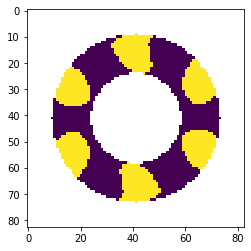

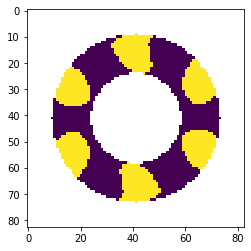

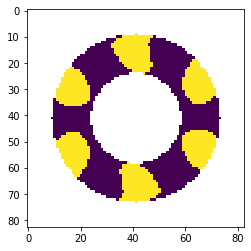

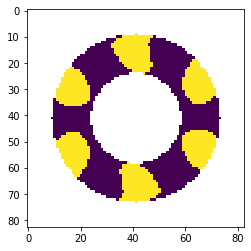

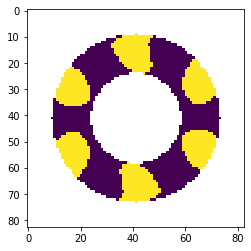

grid score: 1.1243589866172008
grid score: 1.102554760651274
grid score: 1.0836336378885036
grid score: 1.0352023263541912
grid score: 0.9776151678115506
grid score: 0.8985073862177781
grid score: 0.8318744667283702
grid score: 0.7556159999800656
grid score: 0.6972153867189229
grid score: 1.1137628763566458
grid score: 1.0610644841789265
grid score: 1.017144429307482
grid score: 0.46266053214528235
grid score: 0.4245877680834408
grid score: 0.38473118265102485
grid score: 0.351267396152778
grid score: 0.3110867816605592
grid score: 0.2813992861090696
grid score: 0.06369211560354004
grid score: 0.06508248523741823
grid score: 0.07263437992363478
grid score: 0.0756105077838126
grid score: 0.06884081692906759
grid score: 0.05988963520227139
grid score: 0.035228101081038354
grid score: 0.20712816641066328
grid score: 0.2415303741107744
grid score: 0.25135964679807904
grid score: 0.20292111931656337
grid score: 0.12299249518875856
grid score: 0.03885394692900862
grid score: -0.0292488541931

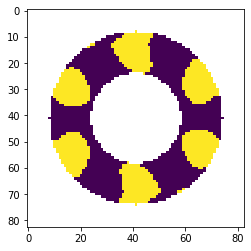

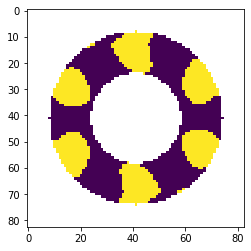

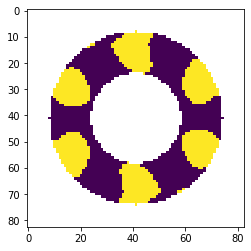

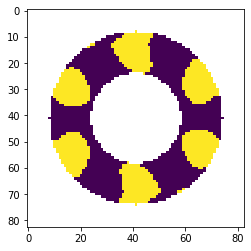

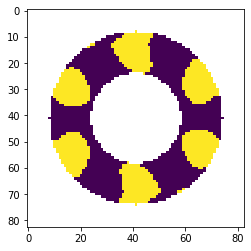

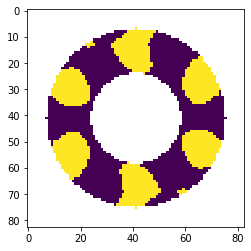

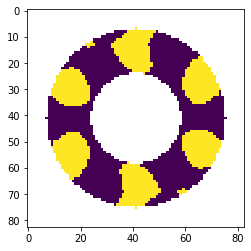

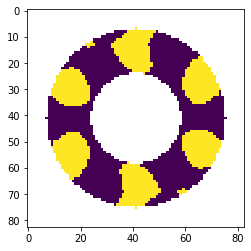

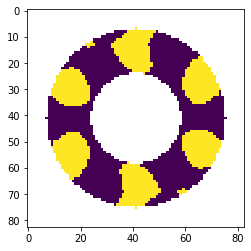

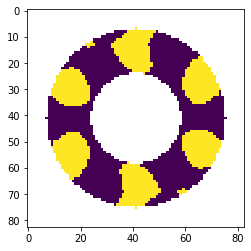

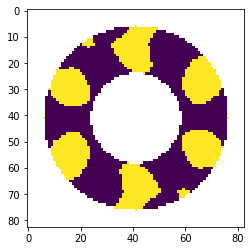

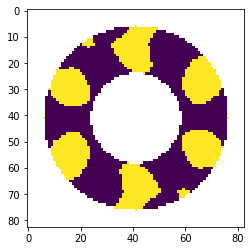

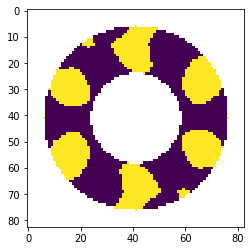

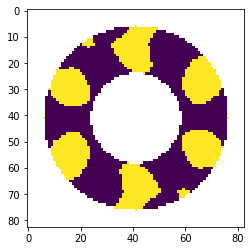

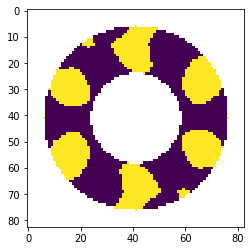

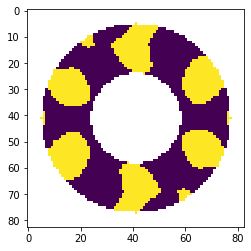

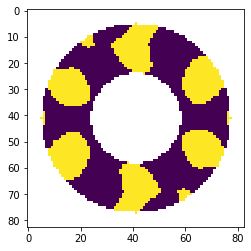

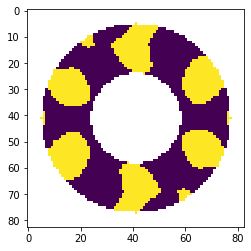

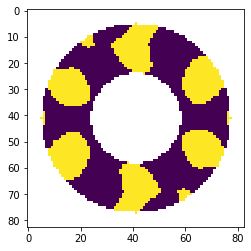

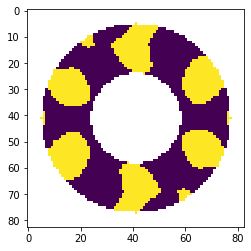

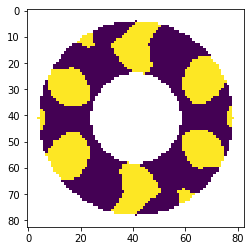

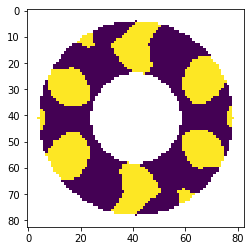

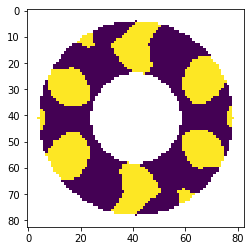

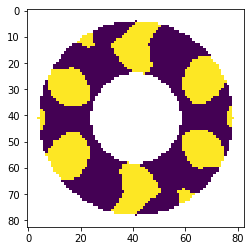

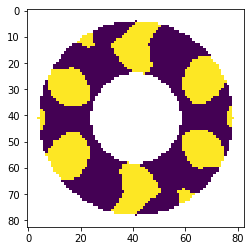

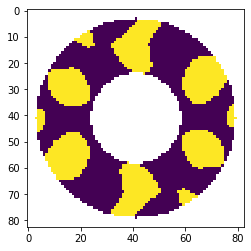

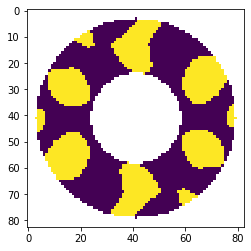

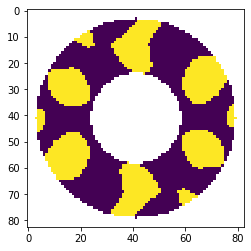

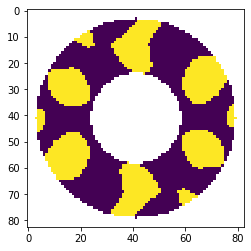

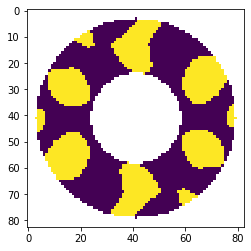

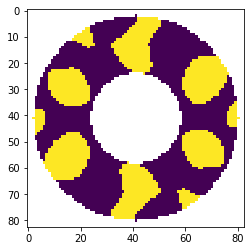

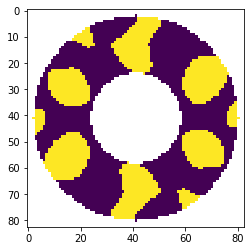

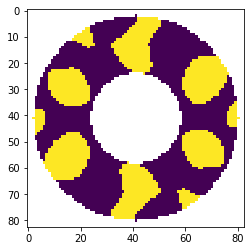

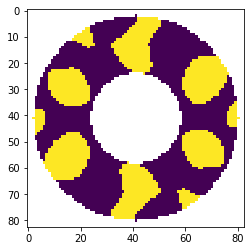

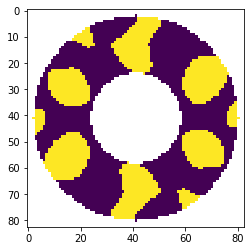

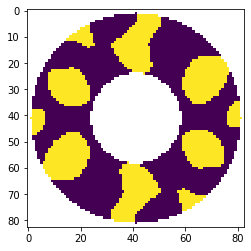

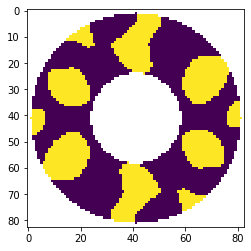

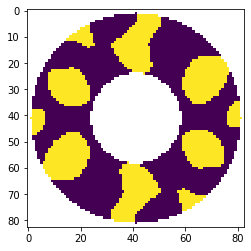

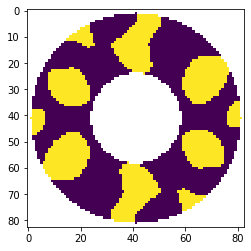

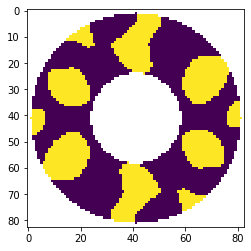

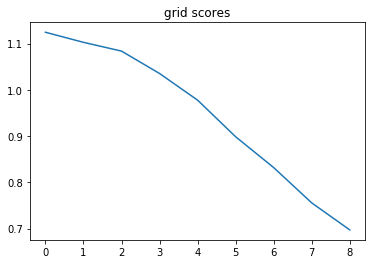

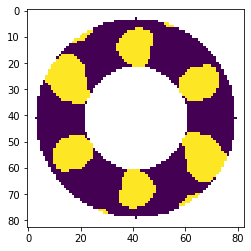

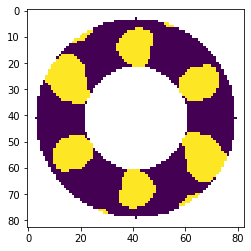

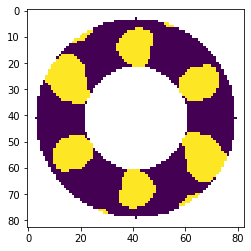

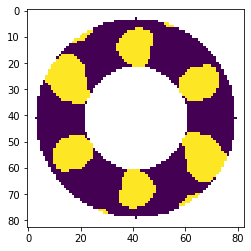

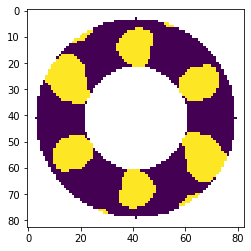

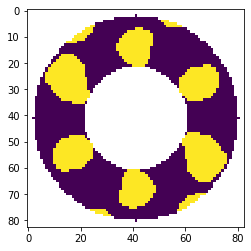

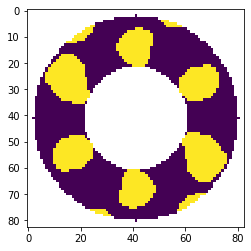

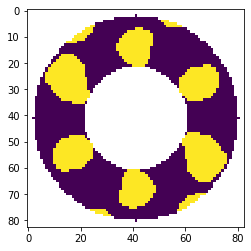

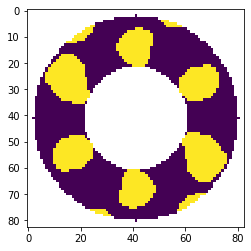

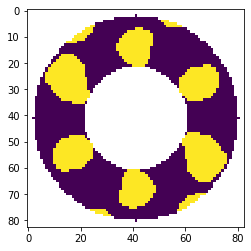

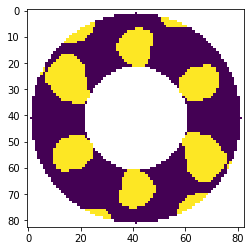

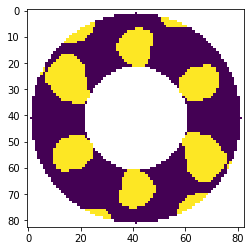

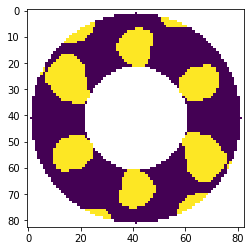

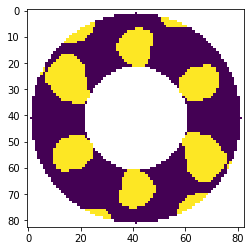

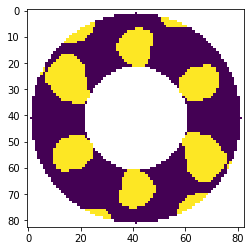

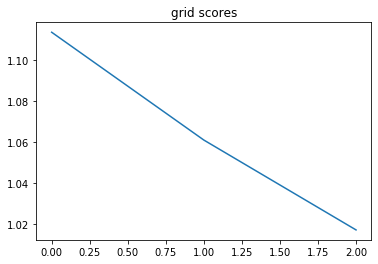

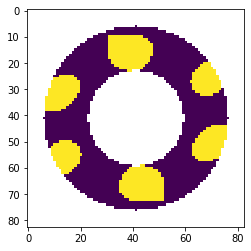

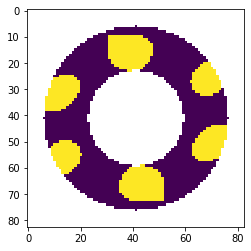

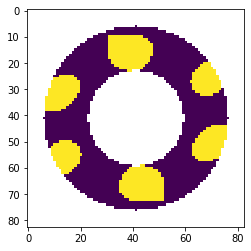

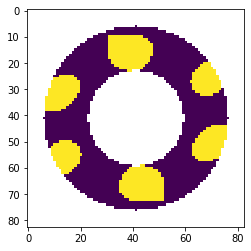

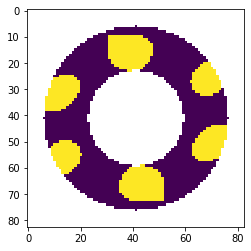

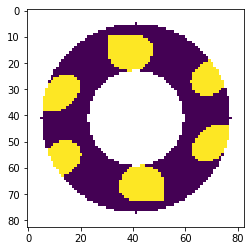

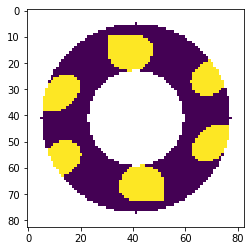

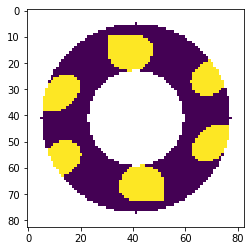

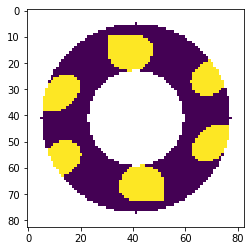

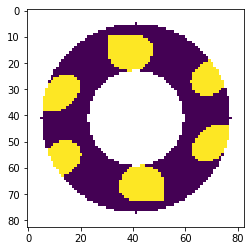

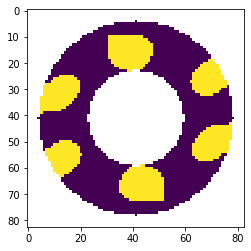

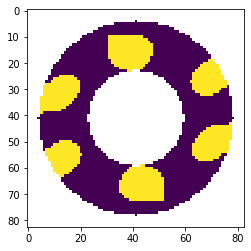

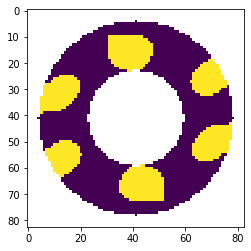

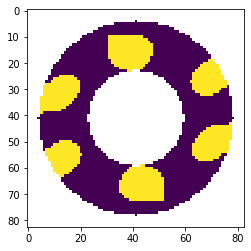

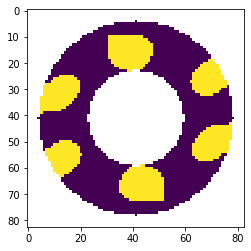

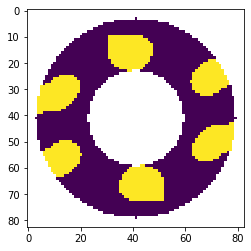

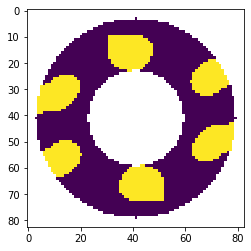

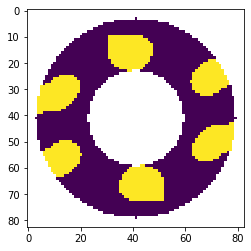

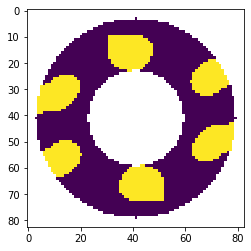

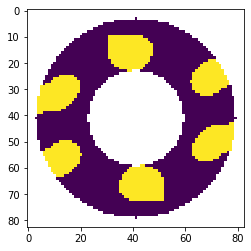

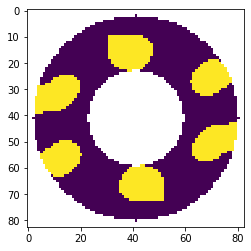

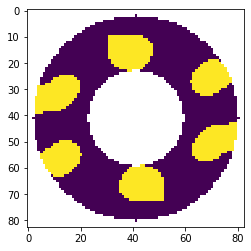

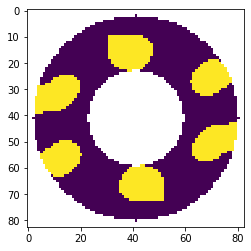

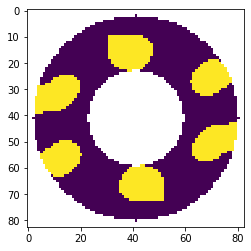

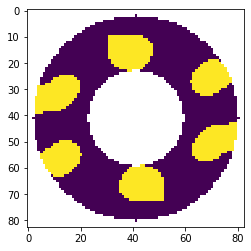

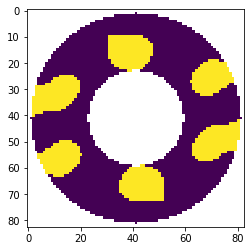

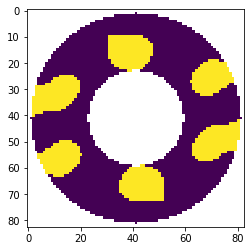

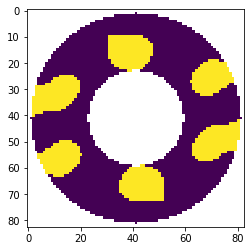

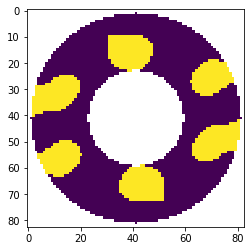

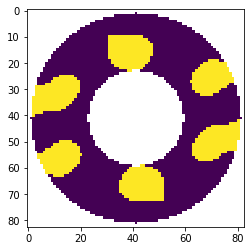

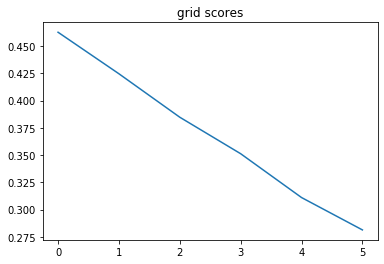

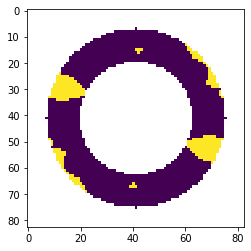

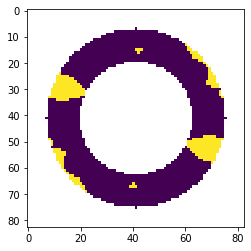

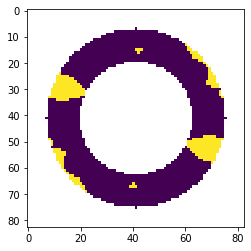

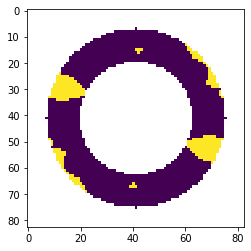

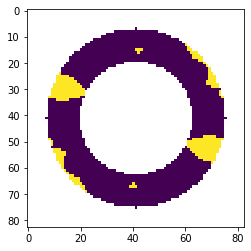

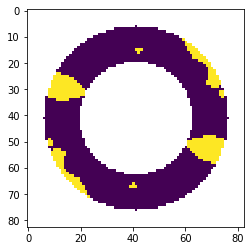

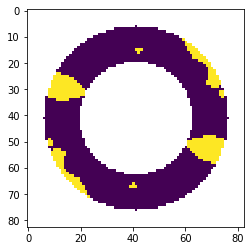

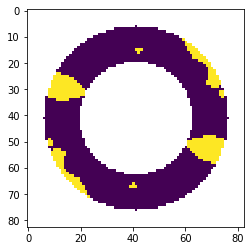

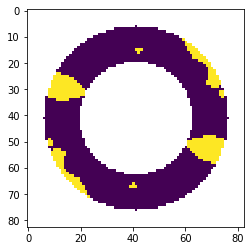

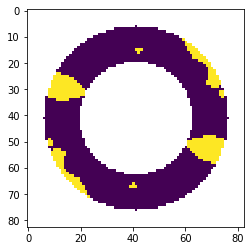

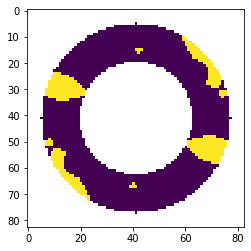

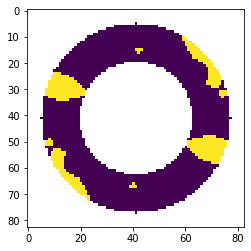

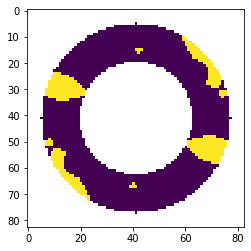

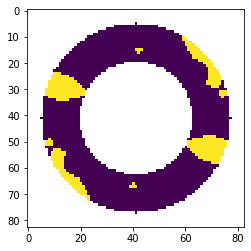

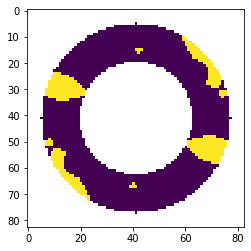

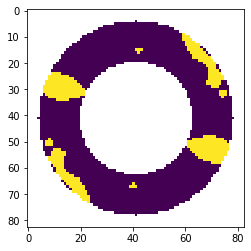

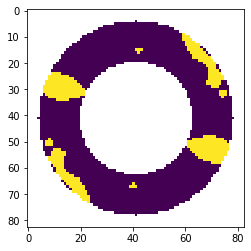

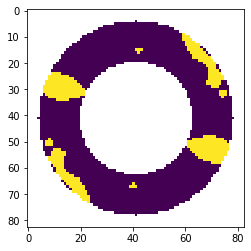

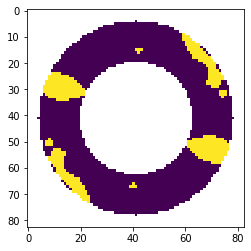

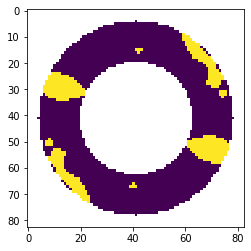

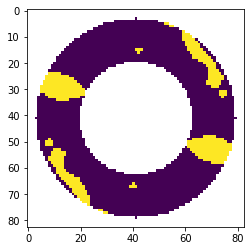

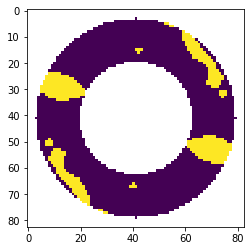

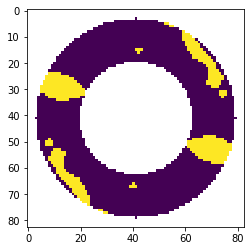

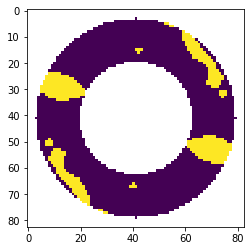

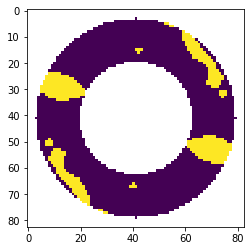

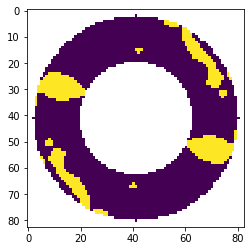

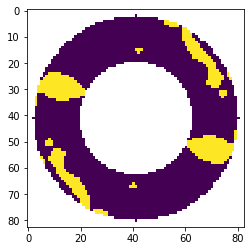

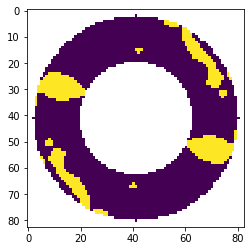

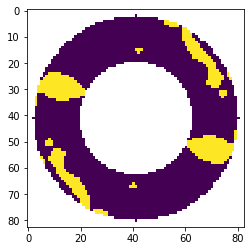

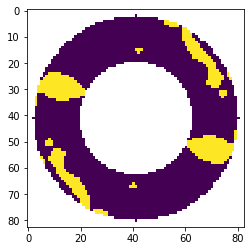

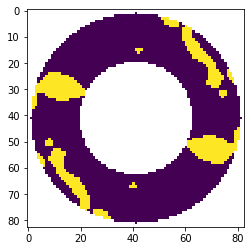

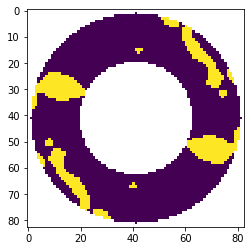

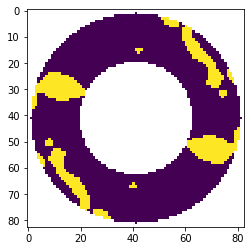

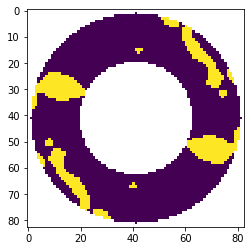

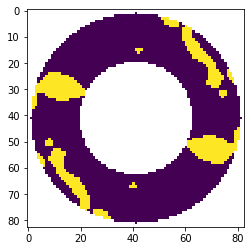

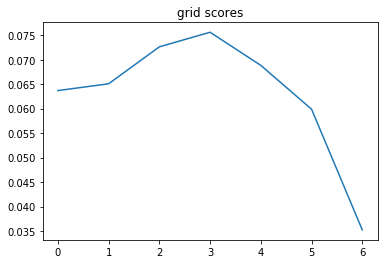

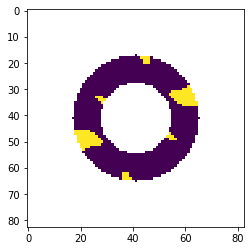

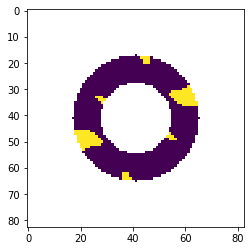

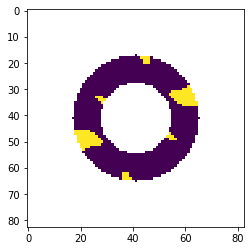

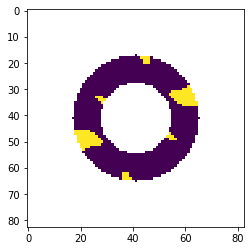

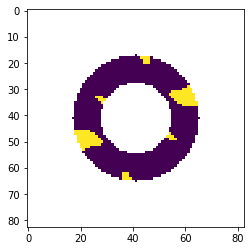

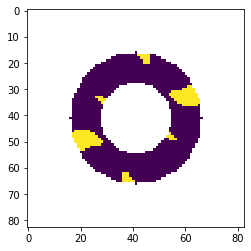

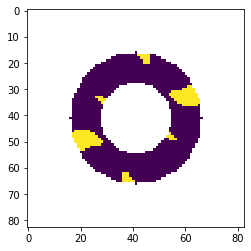

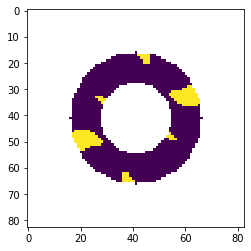

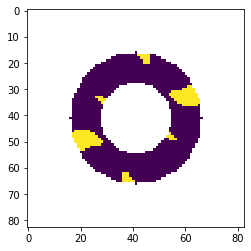

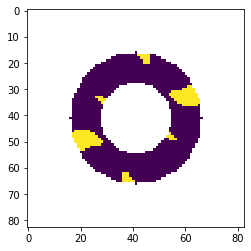

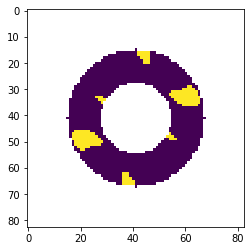

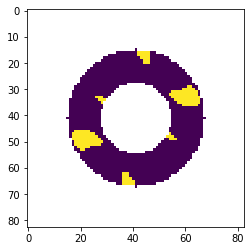

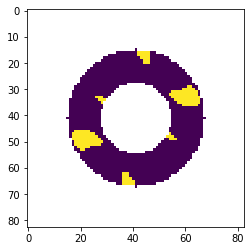

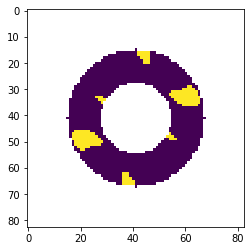

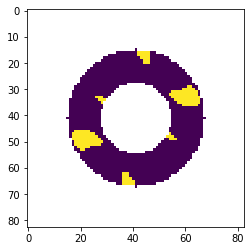

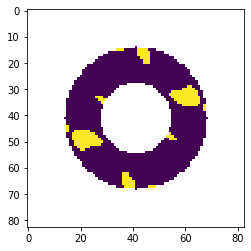

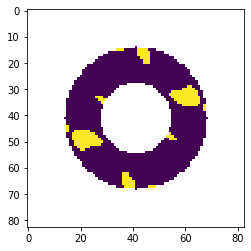

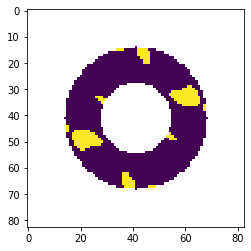

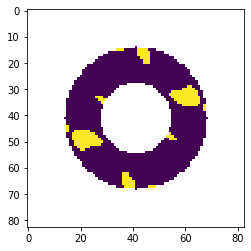

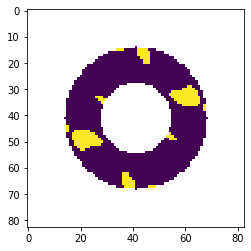

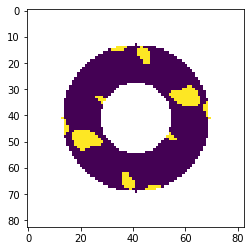

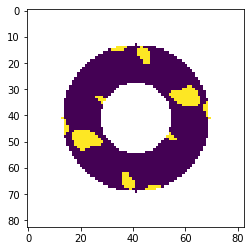

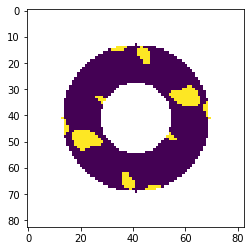

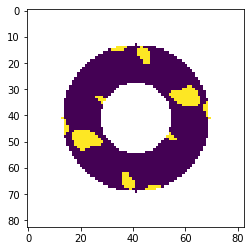

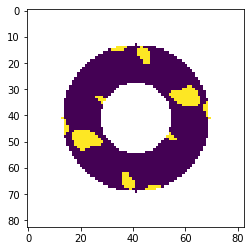

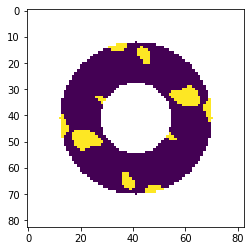

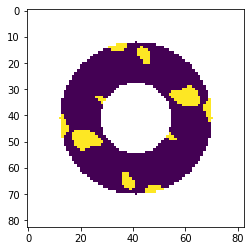

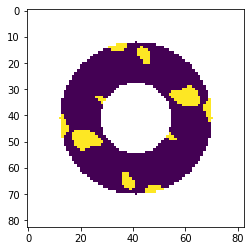

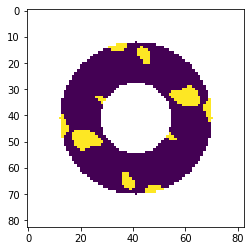

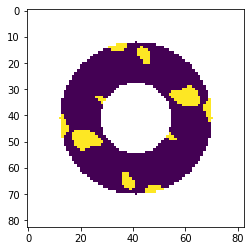

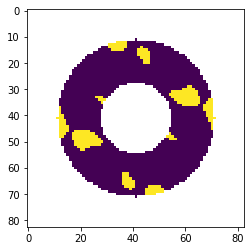

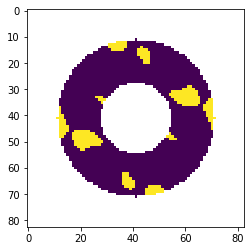

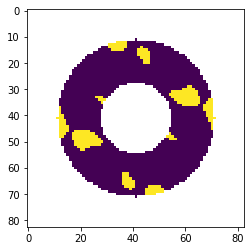

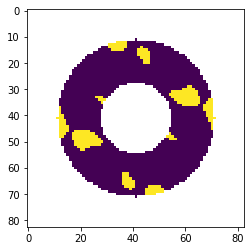

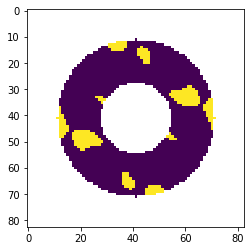

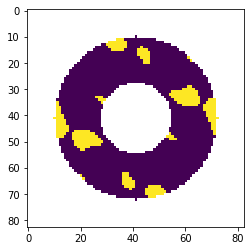

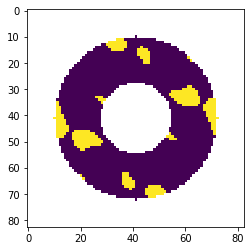

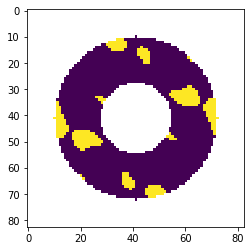

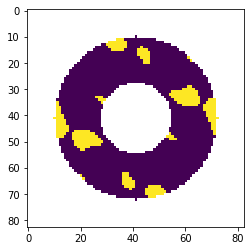

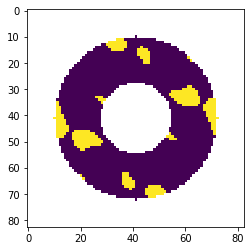

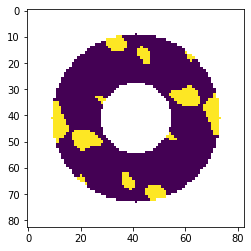

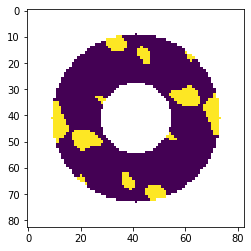

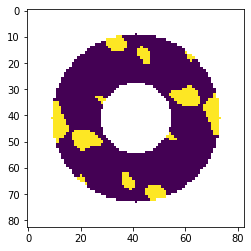

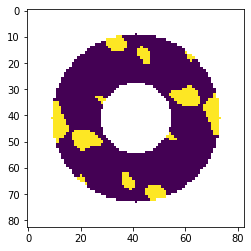

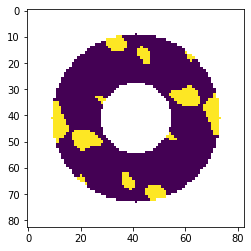

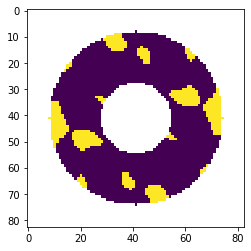

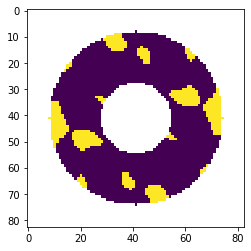

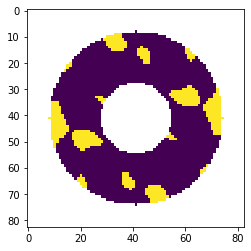

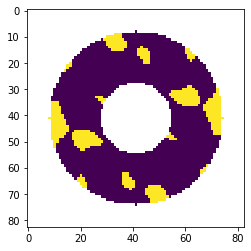

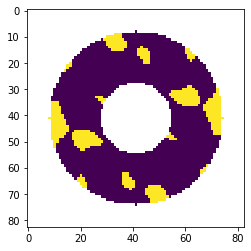

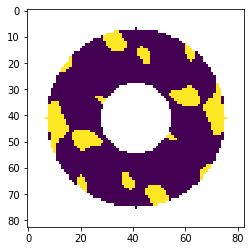

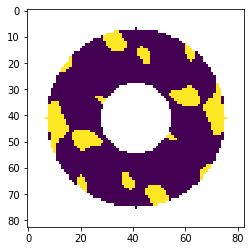

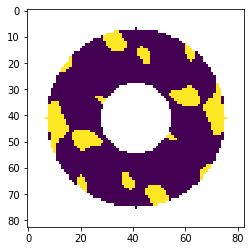

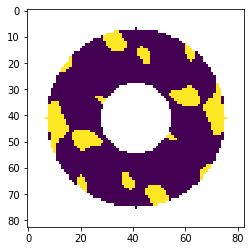

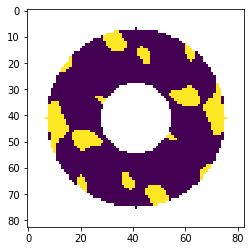

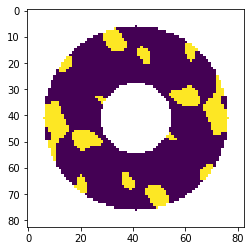

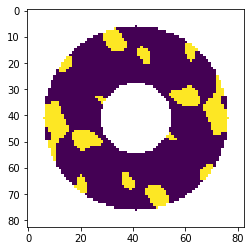

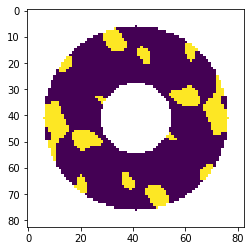

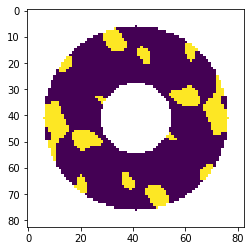

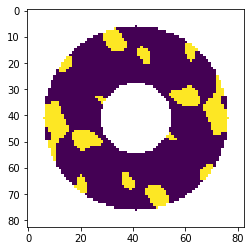

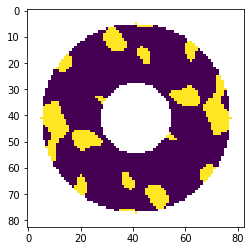

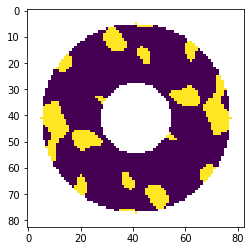

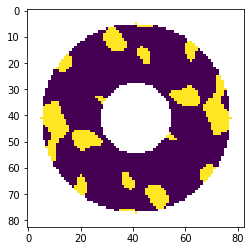

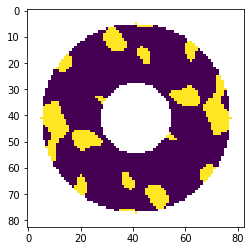

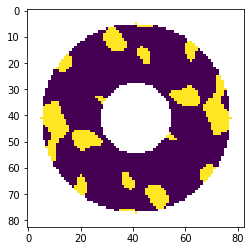

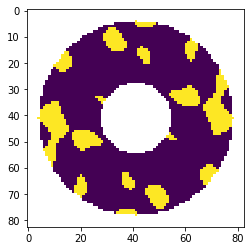

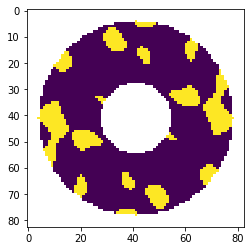

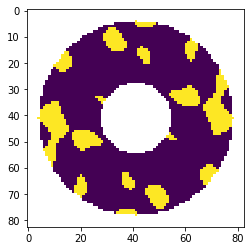

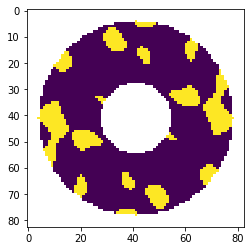

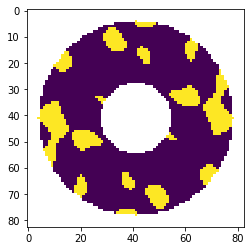

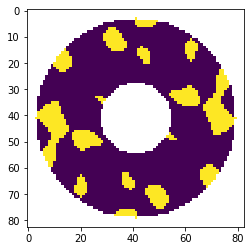

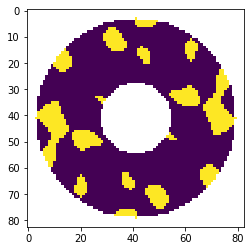

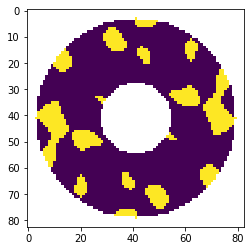

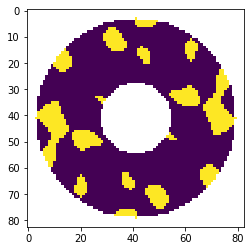

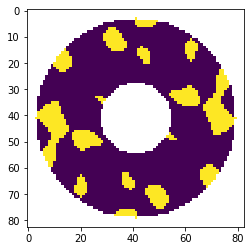

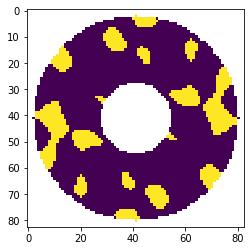

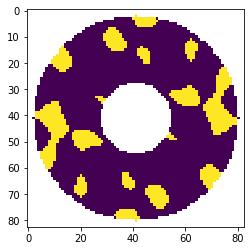

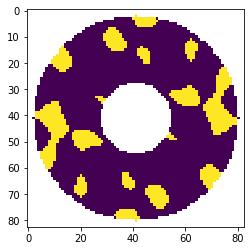

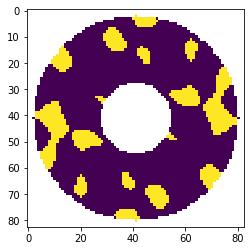

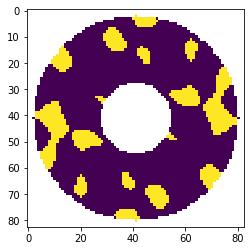

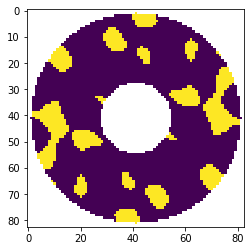

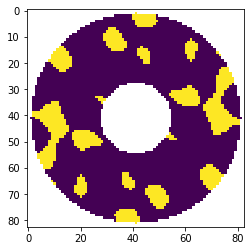

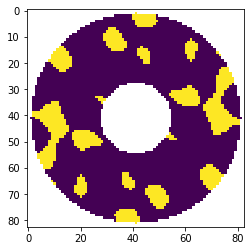

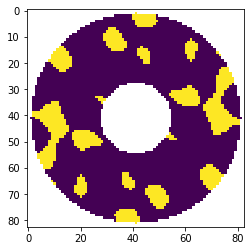

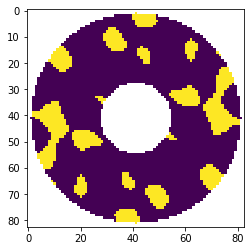

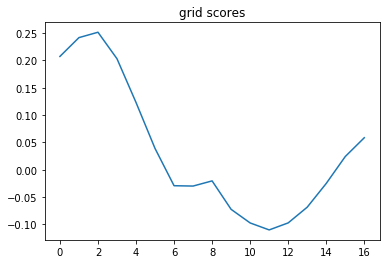

ValueError: max() arg is an empty sequence

In [9]:
spatial_firing_with_grid_data = process_grid_data(spatial_firing)
